In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("irfansheriff/parkinsons-brain-mri-dataset")

print("Path to dataset files:", path)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

# ==============
# 1. Configuration
# ==============
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30

# ==============
# 2. Kaggle Data Loading
# ==============
# For Kaggle notebook
input_path = Path('/root/.cache/kagglehub/datasets/irfansheriff/parkinsons_dataset')  # Update with your dataset name

# Verify dataset structure
print("Dataset contents:")
for dirpath, dirnames, filenames in os.walk(input_path):
    print(f"Found {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

# Create dataframe with proper paths
def get_file_paths(directory):
    return [str(path) for path in Path(directory).glob('*/*.png')]

df = pd.DataFrame({'path': get_file_paths(input_path)})
df['label'] = df['path'].apply(lambda x: 0 if 'normal' in x else 1)  # Binary classification

# Check class distribution
print("\nClass distribution:")
print(df['label'].value_counts())

# ==============
# 3. Data Pipeline (Kaggle optimized)
# ==============
def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.keras.applications.efficientnet.preprocess_input(img)  # EfficientNet specific
    return img, label

# Train-test split (stratified)
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

# Create TensorFlow datasets
def create_dataset(df, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices(
        (df['path'].values, df['label'].values)
    )
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(BATCH_SIZE)
    return dataset.prefetch(tf.data.AUTOTUNE)

train_ds = create_dataset(train_df, shuffle=True)
test_ds = create_dataset(test_df)



Dataset contents:
Found 2 directories and 0 images in '/root/.cache/kagglehub/datasets/irfansheriff/parkinsons_dataset'
Found 0 directories and 221 images in '/root/.cache/kagglehub/datasets/irfansheriff/parkinsons_dataset/parkinson'
Found 0 directories and 610 images in '/root/.cache/kagglehub/datasets/irfansheriff/parkinsons_dataset/normal'

Class distribution:
label
0    610
1    221
Name: count, dtype: int64


In [ ]:
def build_model():
    base_model = tf.keras.applications.EfficientNetB4(
        include_top=False,
        weights='imagenet',
        input_shape=(*IMG_SIZE, 3)
    )
    base_model.trainable = False  # Freeze base model
    #Transfer Learning
    inputs = tf.keras.Input(shape=(*IMG_SIZE, 3))
    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

model = build_model()

In [ ]:
class_weights = {0: 1.0, 1: len(train_df[train_df['label']==0])/len(train_df[train_df['label']==1])}

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=5,
        monitor='val_auc',
        mode='max',
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.keras',  # Changed from .h5 to .keras
        save_best_only=True,
        monitor='val_auc',
        mode='max'
    )
]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 236s 10s/step - accuracy: 0.5647 - auc: 0.7230 - loss: 0.9470 - val_accuracy: 0.8802 - val_auc: 0.9468 - val_loss: 0.4832 - learning_rate: 1.0000e-04
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 193s 9s/step - accuracy: 0.8254 - auc: 0.8868 - loss: 0.7082 - val_accuracy: 0.9162 - val_auc: 0.9894 - val_loss: 0.3953 - learning_rate: 1.0000e-04
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 183s 8s/step - accuracy: 0.8609 - auc: 0.9546 - loss: 0.5863 - val_accuracy: 0.9461 - val_auc: 0.9958 - val_loss: 0.3238 - learning_rate: 1.0000e-04
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 206s 9s/step - accuracy: 0.8886 - auc: 0.9571 - loss: 0.5116 - val_accuracy: 0.9701 - val_auc: 0.9964 - val_loss: 0.2469 - learning_rate: 1.0000e-04
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 183s 9s/step - accuracy: 0.9437 - auc: 0.9868 - loss: 0.3757 - val_accuracy: 0.9701 - val_auc: 0.9976 - val_loss: 0.2048 - learning_rate: 1.0000e-04
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 179s 9s/step - accuracy: 0

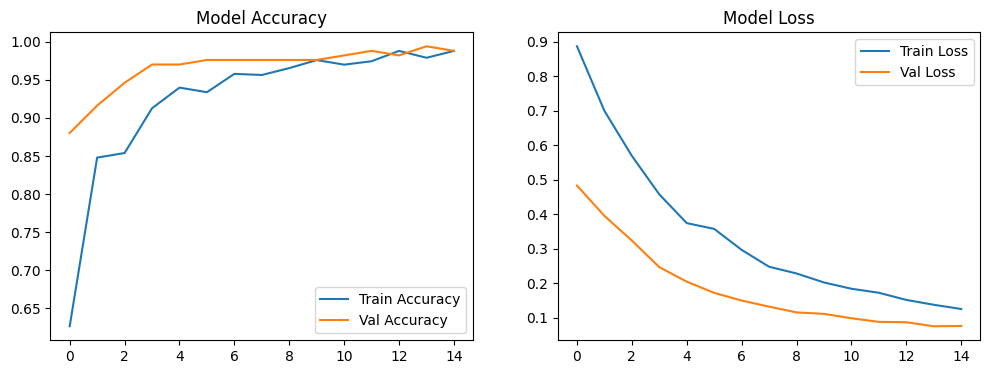

6/6 ━━━━━━━━━━━━━━━━━━━━ 51s 7s/step

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.97      0.98       123
   Parkinson       0.92      1.00      0.96        44

    accuracy                           0.98       167
   macro avg       0.96      0.98      0.97       167
weighted avg       0.98      0.98      0.98       167



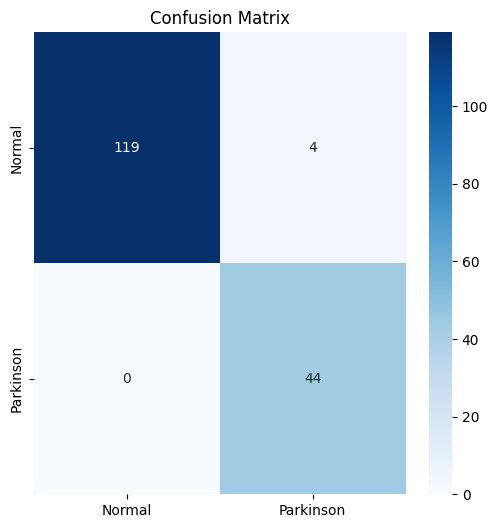

In [ ]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.legend()
    plt.show()

plot_history(history)

# Generate predictions
y_pred = model.predict(test_ds)
y_pred = (y_pred > 0.5).astype(int)
y_true = test_df['label'].values

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Parkinson']))

# Confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_true, y_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Parkinson'],
            yticklabels=['Normal', 'Parkinson'])
plt.title('Confusion Matrix')
plt.show()


In [ ]:
_, test_accuracy, _ = model.evaluate(test_ds)  # Ignore loss and AUC
print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")

6/6 ━━━━━━━━━━━━━━━━━━━━ 36s 6s/step - accuracy: 0.9847 - auc: 0.9988 - loss: 0.1044

Test Accuracy: 97.60%


In [ ]:
import numpy as np
sample_images = test_df.sample(3)

for _, row in sample_images.iterrows():
    img = tf.keras.utils.load_img(row['path'], target_size=IMG_SIZE)
    img_array = tf.keras.utils.img_to_array(img)/255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred_prob = model.predict(img_array, verbose=0)[0][0]
    pred_label = 'Parkinson' if pred_prob > 0.5 else 'Normal'

    print(f"\nImage: {Path(row['path']).name}")
    print(f"True Label: {'Parkinson' if row['label'] == 1 else 'Normal'}")
    print(f"Predicted: {pred_label} (score: {pred_prob:.4f})")
    print(f"Confidence: {max(pred_prob, 1-pred_prob):.1%}")


Image: T2W_TSE_011.png
True Label: Parkinson
Predicted: Normal (score: 0.4059)
Confidence: 59.4%

Image: ep2d_diff_3scan_trace_p2_TRACEW_DFC_060.png
True Label: Normal
Predicted: Normal (score: 0.4472)
Confidence: 55.3%

Image: SWI_Images_005.png
True Label: Normal
Predicted: Normal (score: 0.4280)
Confidence: 57.2%


In [ ]:
model.save('parkinson_model.h5')

In [ ]:
import numpy as np

def horned_lizard_optimization(objective_function, bounds, population_size, iterations):
    """
    Implements the Horned Lizard Optimization Algorithm (HLOA).

    Args:
        objective_function: The function to minimize. Takes a parameter vector as input.
        bounds: A list of tuples, where each tuple is (lower_bound, upper_bound) for each parameter.
        population_size: The number of horned lizards (candidate solutions).
        iterations: The maximum number of iterations.

    Returns:
        A tuple containing the best parameter vector found and the corresponding best fitness value.
    """
    num_parameters = len(bounds)
    population = np.random.uniform([b[0] for b in bounds], [b[1] for b in bounds], size=(population_size, num_parameters))
    fitness = np.array([objective_function(lizard) for lizard in population])

    best_lizard_index = np.argmin(fitness)
    best_lizard = population[best_lizard_index].copy()
    best_fitness = fitness[best_lizard_index]

    for iteration in range(iterations):
        new_population = np.copy(population)

        for i in range(population_size):
            # Simulate hunting behavior
            j = np.random.randint(population_size)
            if fitness[i] < fitness[j]:  # Lizard i is better, j moves towards i
                alpha = np.random.rand()
                new_population[j] = population[j] + alpha * (population[i] - population[j])
            else:  # Lizard j is better, i moves towards j
                alpha = np.random.rand()
                new_population[i] = population[i] + alpha * (population[j] - population[i])

            # Simulate escaping predator behavior (random walk with bounds check)
            delta = np.random.normal(0, 0.1, size=num_parameters) # Small random step
            new_lizard = new_population[i] + delta

            # Apply bounds
            for k in range(num_parameters):
                new_lizard[k] = np.clip(new_lizard[k], bounds[k][0], bounds[k][1])

            new_population[i] = new_lizard

        # Evaluate new population and update
        new_fitness = np.array([objective_function(lizard) for lizard in new_population])

        for i in range(population_size):
            if new_fitness[i] < fitness[i]:
                population[i] = new_population[i].copy()
                fitness[i] = new_fitness[i]

        current_best_lizard_index = np.argmin(fitness)
        if fitness[current_best_lizard_index] < best_fitness:
            best_fitness = fitness[current_best_lizard_index]
            best_lizard = population[current_best_lizard_index].copy()

        # Print progress (optional)
        # print(f"Iteration {iteration+1}/{iterations}, Best Fitness: {best_fitness:.4f}")

    return best_lizard, best_fitness

# Example usage (dummy objective function and bounds)
def dummy_objective(params):
    return (params[0] - 2)**2 + (params[1] + 3)**2

dummy_bounds = [(-10, 10), (-10, 10)]
# best_params, best_fit = horned_lizard_optimization(dummy_objective, dummy_bounds, 50, 100)
# print(f"Best parameters: {best_params}")
# print(f"Best fitness: {best_fit}")

In [ ]:
def objective_function(params):
    """
    Objective function for HLOA to minimize (maximize validation AUC).

    Args:
        params: A list or array of parameters [learning_rate, dropout_rate].

    Returns:
        Negative validation AUC (since HLOA minimizes).
    """
    learning_rate, dropout_rate = params

    # Build and compile the model with the given parameters
    base_model = tf.keras.applications.EfficientNetB4(
        include_top=False,
        weights='imagenet',
        input_shape=(*IMG_SIZE, 3)
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(*IMG_SIZE, 3))
    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    # Train the model for a few epochs (reduced for optimization)
    # Use a subset of data or fewer epochs to speed up optimization
    history = model.fit(
        train_ds.take(5), # Use a smaller subset of data for faster evaluation
        validation_data=test_ds.take(2), # Use a smaller subset of data
        epochs=5, # Reduced epochs for faster evaluation
        class_weight=class_weights,
        verbose=0 # Suppress output
    )

    # Return negative validation AUC
    return -history.history['val_auc'][-1]

# Define bounds for the parameters (learning_rate, dropout_rate)
bounds = [(1e-5, 1e-3), (0.1, 0.7)]

# HLOA parameters
population_size = 20
iterations = 10

# Run HLOA
best_params, best_fitness = horned_lizard_optimization(objective_function, bounds, population_size, iterations)

print("Best parameters found by HLOA:")
print(f"  Learning Rate: {best_params[0]:.6f}")
print(f"  Dropout Rate: {best_params[1]:.4f}")
print(f"Best (minimized) objective value: {best_fitness:.4f}")

# Store the best parameters
best_learning_rate = best_params[0]
best_dropout_rate = best_params[1]

In [ ]:
# Build and compile the model with the best parameters
def build_optimized_model(learning_rate, dropout_rate):
    base_model = tf.keras.applications.EfficientNetB4(
        include_top=False,
        weights='imagenet',
        input_shape=(*IMG_SIZE, 3)
    )
    base_model.trainable = False  # Freeze base model

    inputs = tf.keras.Input(shape=(*IMG_SIZE, 3))
    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)  # Use optimized dropout
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),  # Use optimized learning rate
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

optimized_model = build_optimized_model(best_learning_rate, best_dropout_rate)

# Train the optimized model
history_optimized = optimized_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks, # Use the same callbacks
    verbose=1
)

In [ ]:
# Evaluate the optimized model
_, test_accuracy_optimized, _ = optimized_model.evaluate(test_ds)
print(f"\nTest Accuracy (Optimized Model): {test_accuracy_optimized*100:.2f}%")

# Generate predictions for the optimized model
y_pred_optimized = optimized_model.predict(test_ds)
y_pred_optimized = (y_pred_optimized > 0.5).astype(int)

# Classification report for optimized model
print("\nClassification Report (Optimized Model):")
print(classification_report(y_true, y_pred_optimized, target_names=['Normal', 'Parkinson']))

# Confusion matrix for optimized model
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_true, y_pred_optimized),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Parkinson'],
            yticklabels=['Normal', 'Parkinson'])
plt.title('Confusion Matrix (Optimized Model)')
plt.show()

In [ ]:
print("--- Model Performance Comparison ---")
print(f"Original Model Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Optimized Model Test Accuracy: {test_accuracy_optimized*100:.2f}%")

# You can add more metrics here for comparison if needed (e.g., AUC)
# print(f"Original Model Test AUC: {history.history['val_auc'][-1]:.4f}")
# print(f"Optimized Model Test AUC: {history_optimized.history['val_auc'][-1]:.4f}")

In [ ]:
model.save('original_parkinson_model.h5')
optimized_model.save('optimized_parkinson_model.h5')

print("\nOriginal model saved as 'original_parkinson_model.h5'")
print("Optimized model saved as 'optimized_parkinson_model.h5'")